In [1]:
from stata_preprocessing import *
from llm_simulation import *
from load_environmental_distributions import load_environmental_distribution
# from visualise_responses import *
from fine_tuning_prompts import *
import os
import random
from openai import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stata_data_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\UKHLS_fine_tuning_responses.dta"
base_environmental_views_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Environmental-Views-Variables\\"

In [3]:
stata_data = load_stata_file(stata_data_filepath)
stata_response_wave_eight, stata_response_wave_nine, stata_response_wave_ten = [stata_data[stata_data["wavename"] == wavename] for wavename in [8.0, 9.0, 10.0]]

In [4]:
print(stata_response_wave_ten.head())

          pidp       hidp fihhmnlabgrs_dv     sex                 marstat  \
109302   22445  277059218     5996.049805  female                 Married   
109303   29925  618630018          1666.0  female                Divorced   
109304   76165  141460418          6732.0  female                 Married   
109305  280165  754371618         12333.0  female                 Married   
109306  333205  414800018     4782.819824  female  Single, nvr marr/civ p   

              qfhigh                                           racel_dv  \
109302  inapplicable  british/english/scottish/welsh/northern irish ...   
109303  inapplicable  british/english/scottish/welsh/northern irish ...   
109304  inapplicable  british/english/scottish/welsh/northern irish ...   
109305  inapplicable  british/english/scottish/welsh/northern irish ...   
109306  inapplicable  british/english/scottish/welsh/northern irish ...   

              lnprnt age_dv         gor_dv  ...       agegr10_dv  \
109302  inapplicab

In [5]:
stata_response_wave_ten = preprocess_stata_data(stata_response_wave_ten)

In [6]:
# check scenv_meds value counts
print(stata_response_wave_ten["scenv_meds"].value_counts())

Tend to agree                 4463
Neither agree nor disagree    2870
Strongly agree                2510
Tend to disagree               874
Strongly disagree              261
missing                          0
inapplicable                     0
proxy                            0
refusal                          0
don't know                       0
Name: scenv_meds, dtype: int64


In [7]:
# list the variables in stata_response_wave_ten
print(stata_response_wave_ten.columns)

Index(['sex', 'marstat', 'qfhigh', 'racel_dv', 'lnprnt', 'age_dv', 'gor_dv',
       'urban_dv', 'agegr10_dv', 'jbnssec_dv', 'wavename', 'vote3', 'etariff',
       'scenv_crlf', 'scenv_bccc', 'scenv_pmep', 'scenv_meds', 'scenv_tlat'],
      dtype='object')


In [8]:
# initialise the profiling variables as the list of variables in stata_response_wave_ten excluding the ukhls_variable
ukhls_variable = "scenv_meds"

profiling_variables = [variable for variable in stata_response_wave_ten.columns if variable != ukhls_variable]

In [9]:
def visualise_heatmap(data, ukhls_variable, profile_variable):

    ukhls_variable = data[ukhls_variable]

    # create the crosstab.
    crosstab = pd.crosstab(ukhls_variable, data[profile_variable])

    # convert counts to fractions.
    crosstab_fraction = crosstab.div(crosstab.sum(axis=0), axis=1)

    # plot the heatmap.
    plt.figure(figsize=(10, 6))
    sns.heatmap(crosstab_fraction, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title(f"Fraction of {ukhls_variable.name} by {profile_variable}")
    plt.xlabel(profile_variable)
    plt.ylabel(ukhls_variable.name)

    plt.savefig(f"C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Figures\\Heatmaps\\{ukhls_variable.name}_by_{profile_variable}.png")

    plt.show()

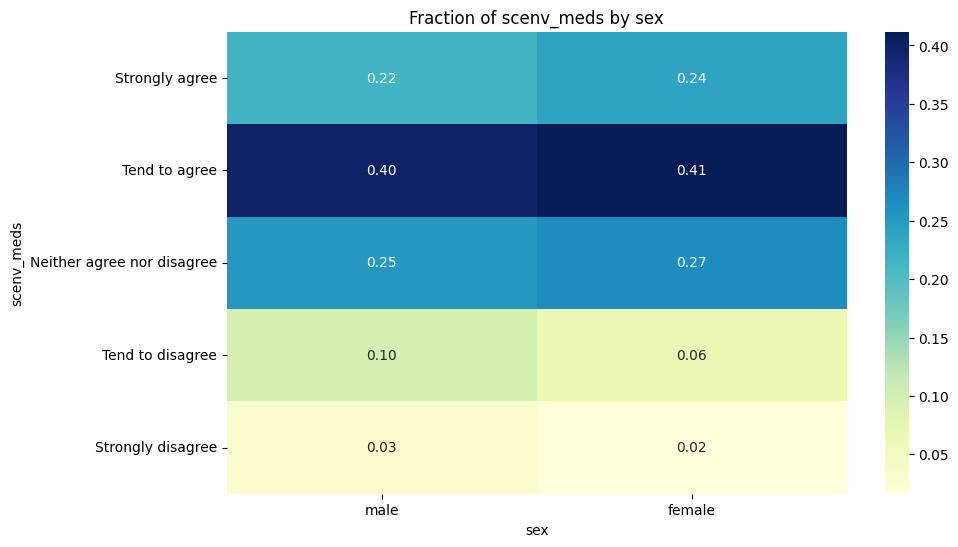

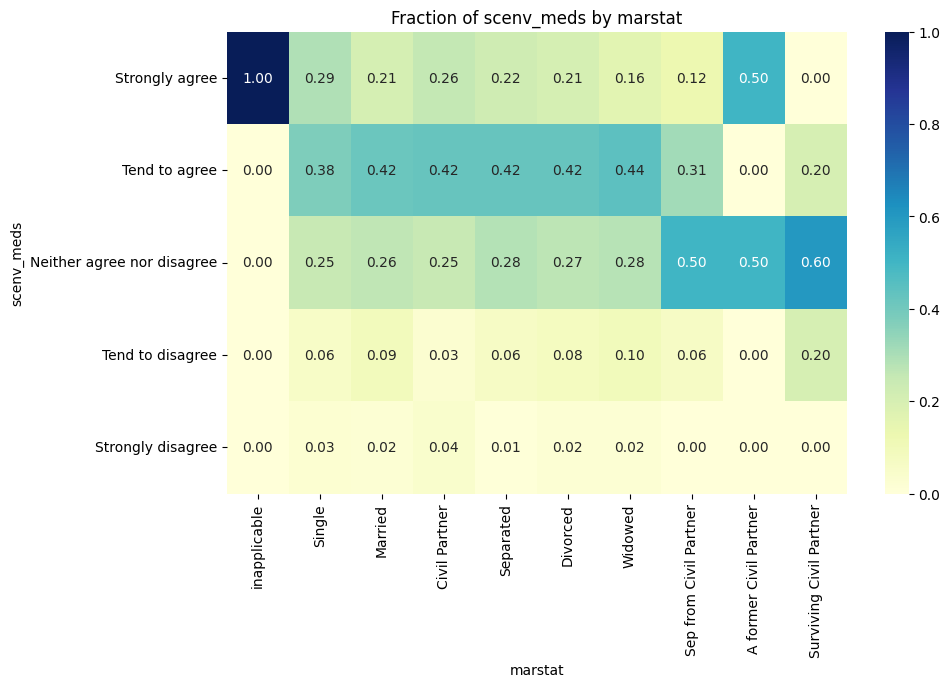

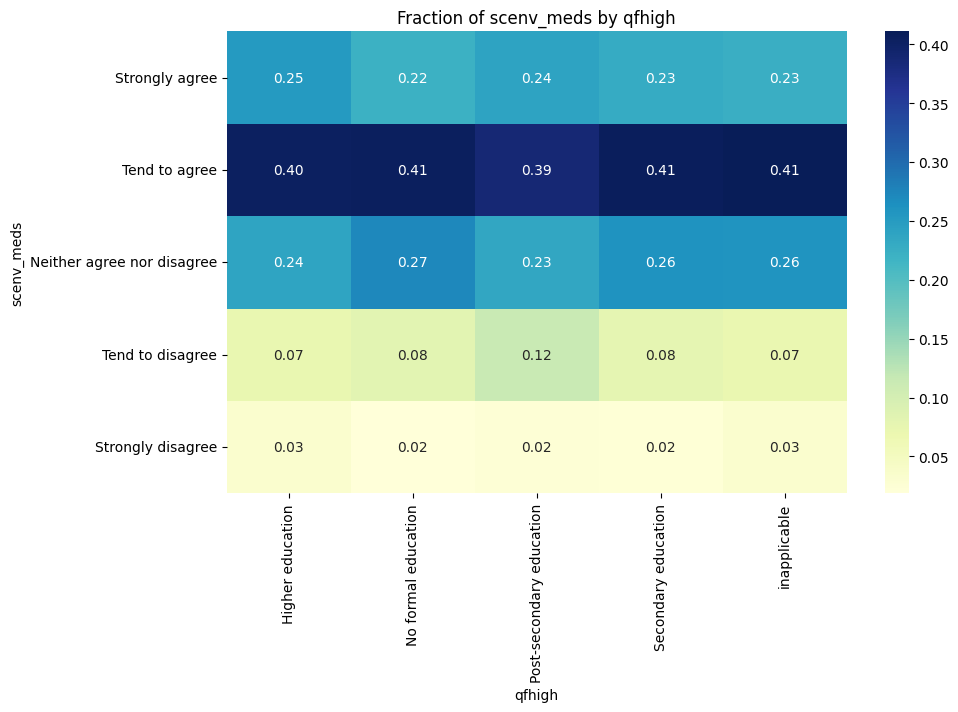

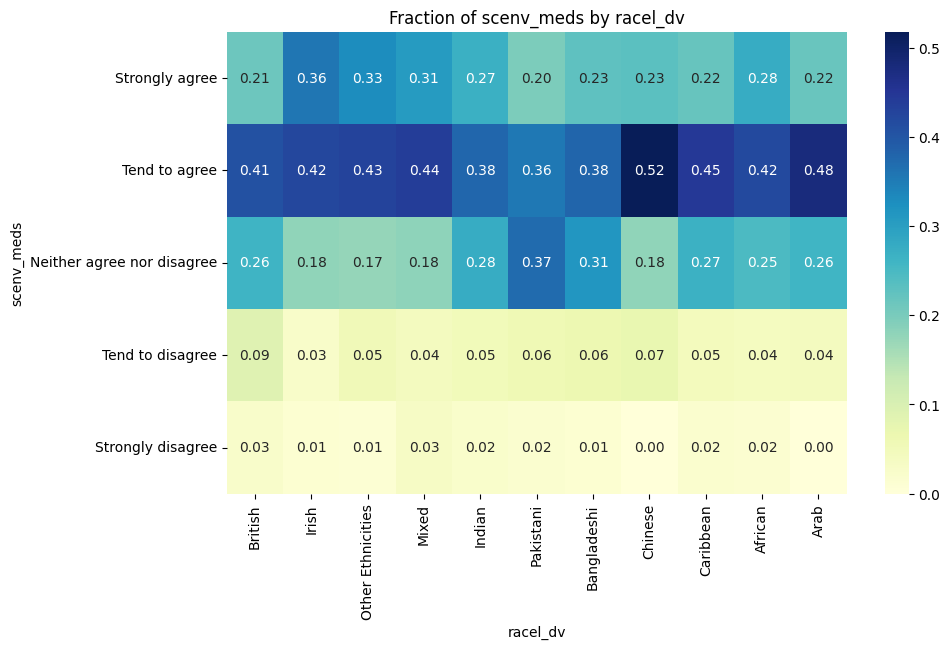

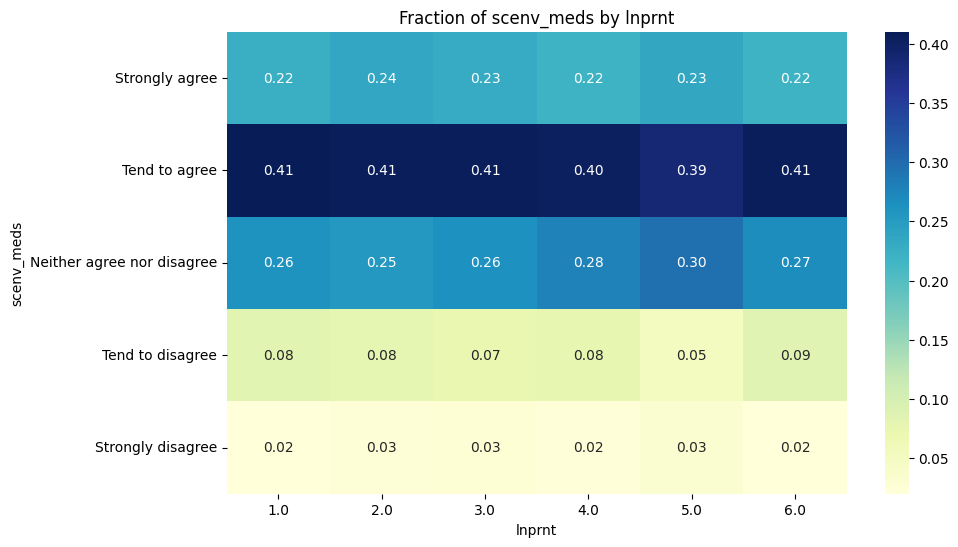

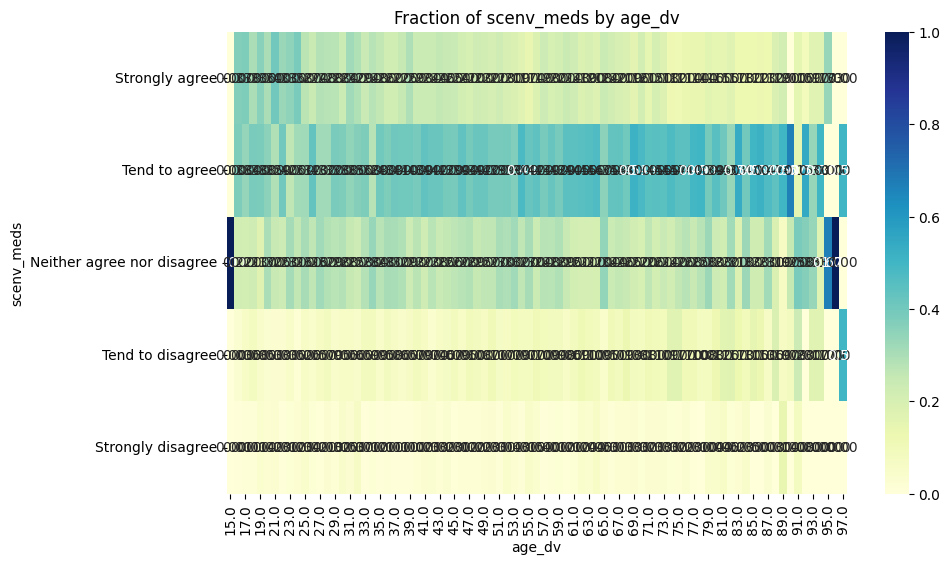

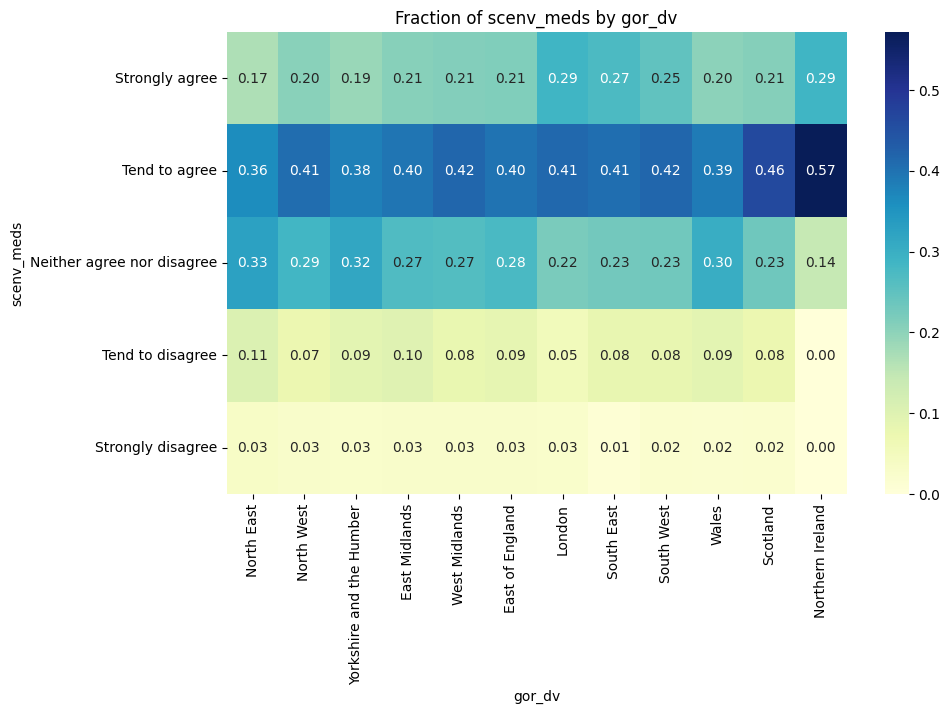

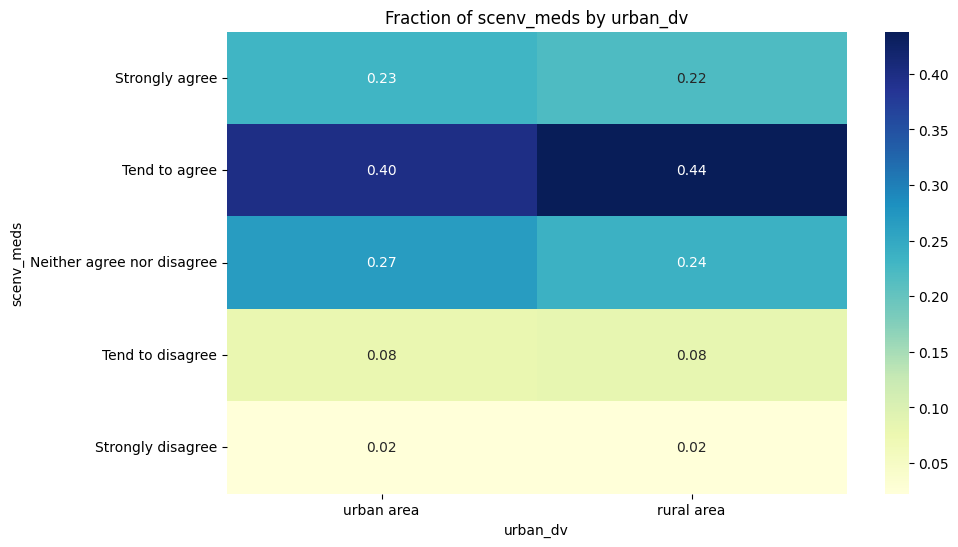

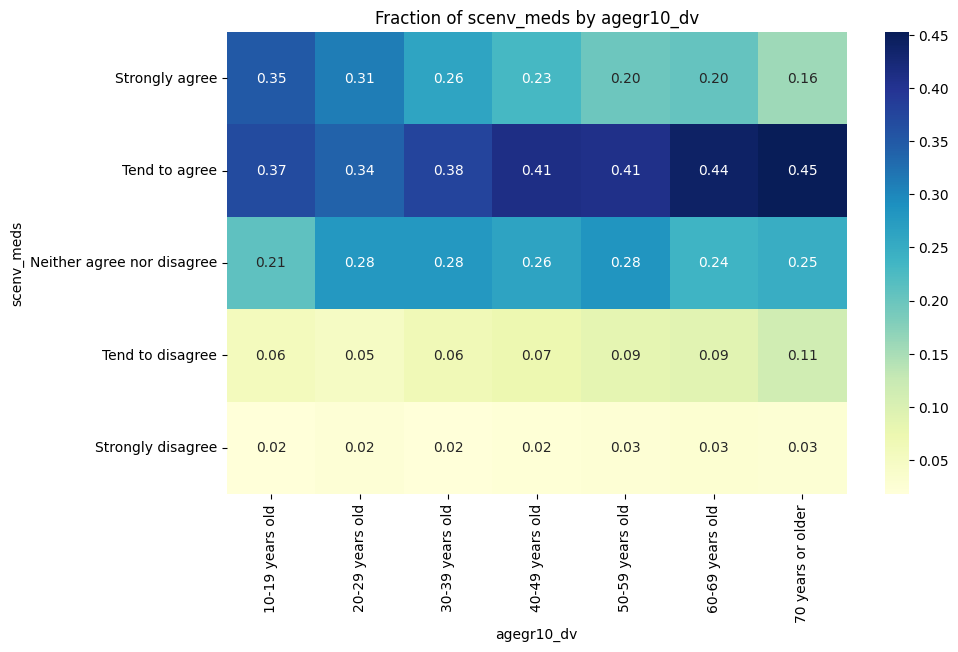

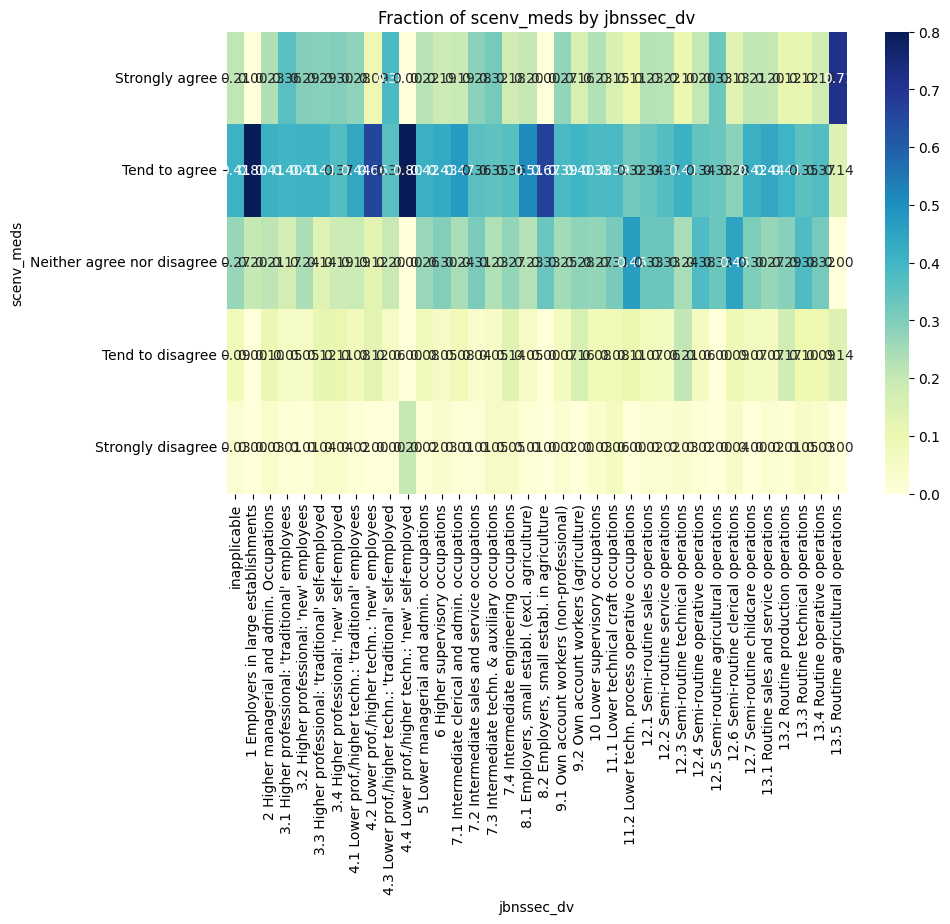

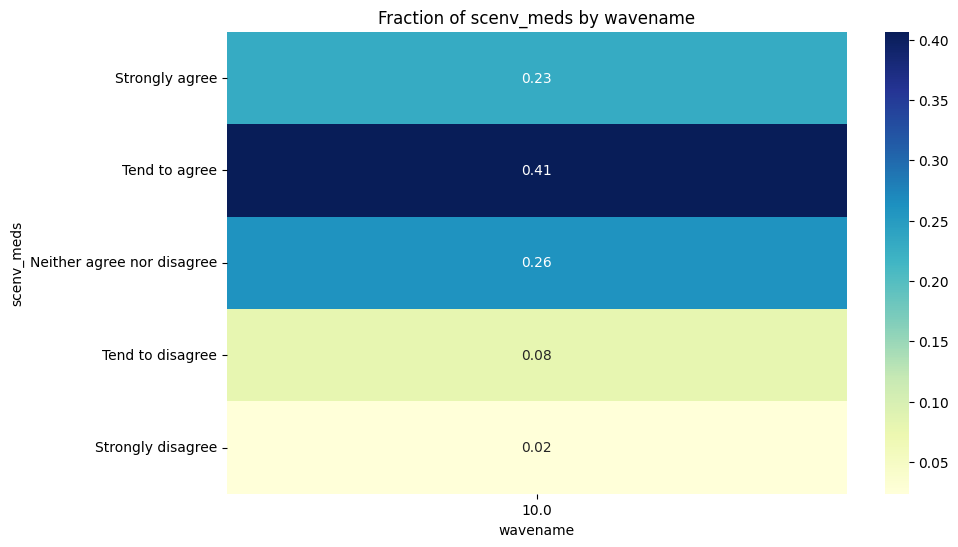

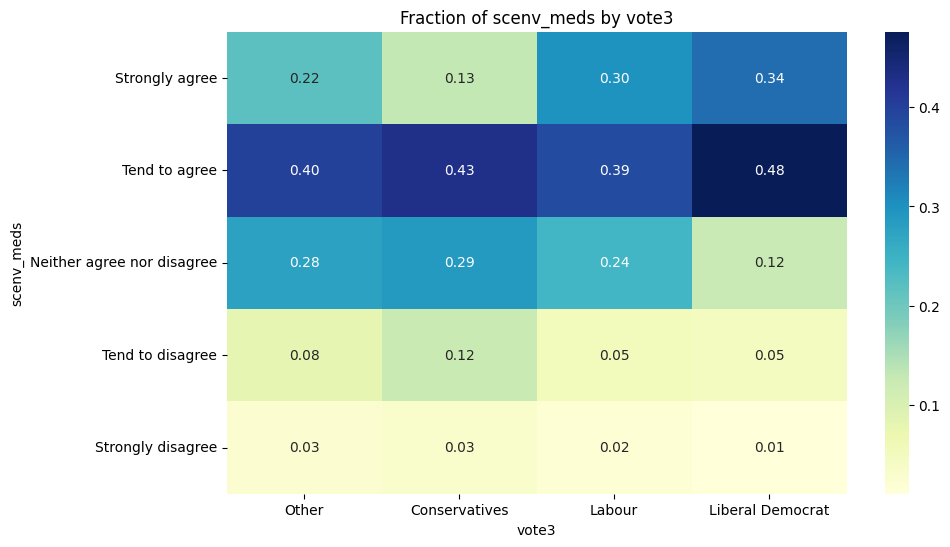

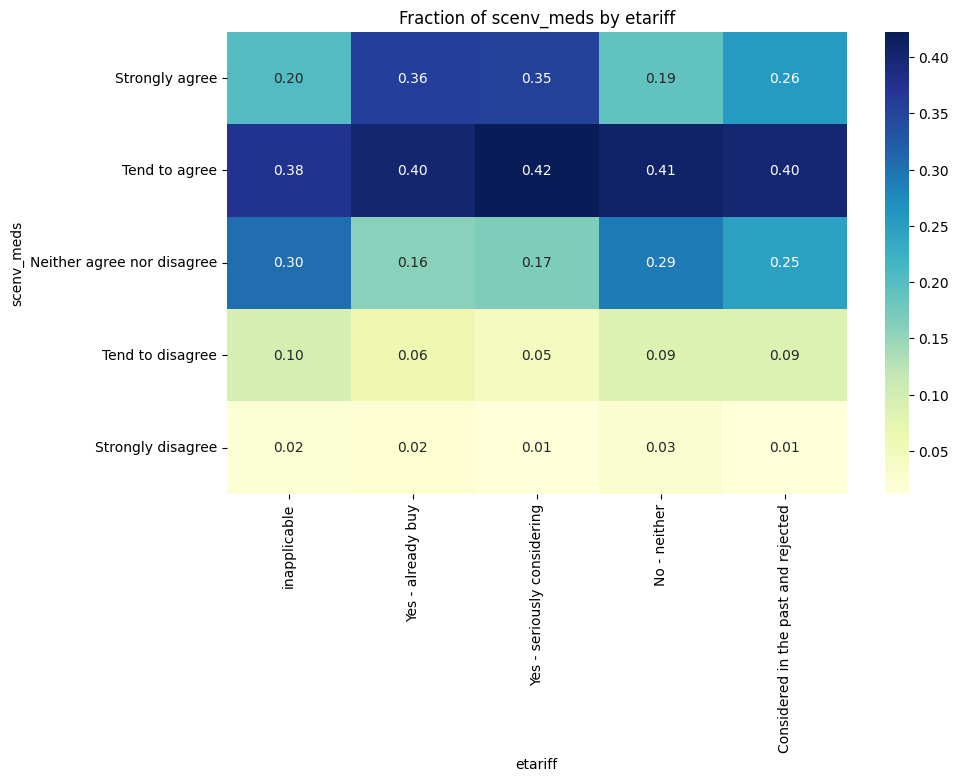

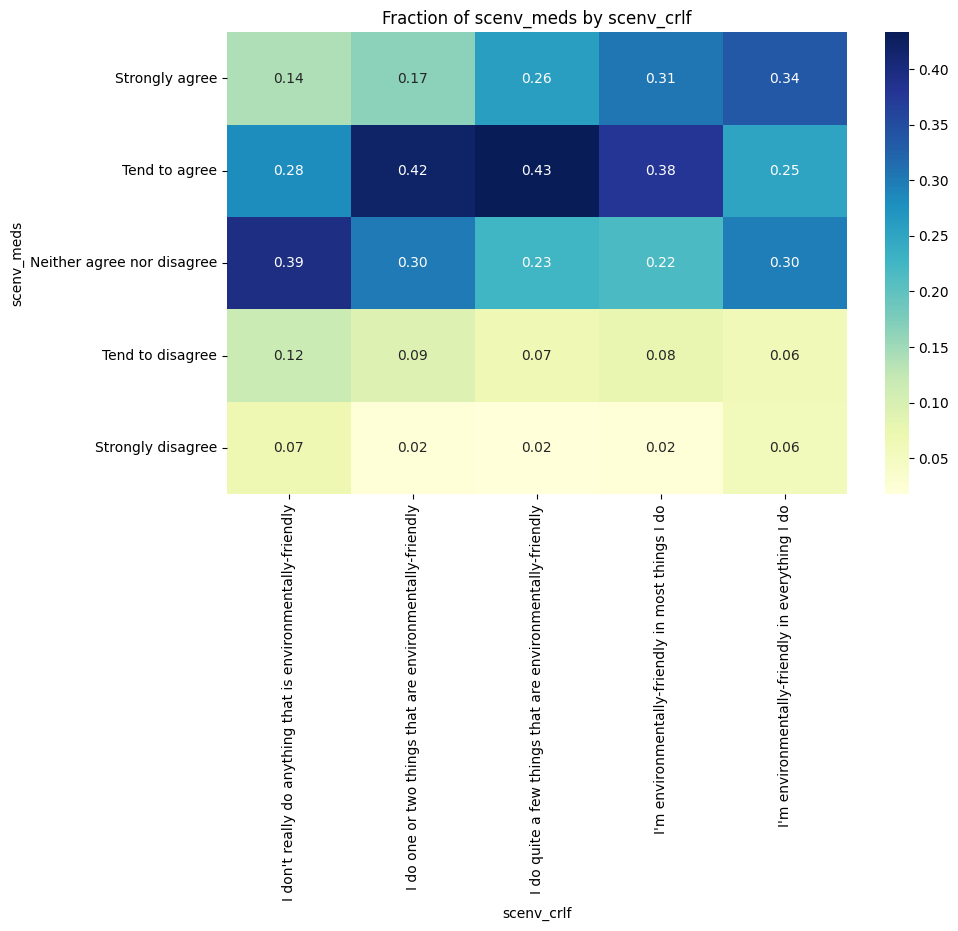

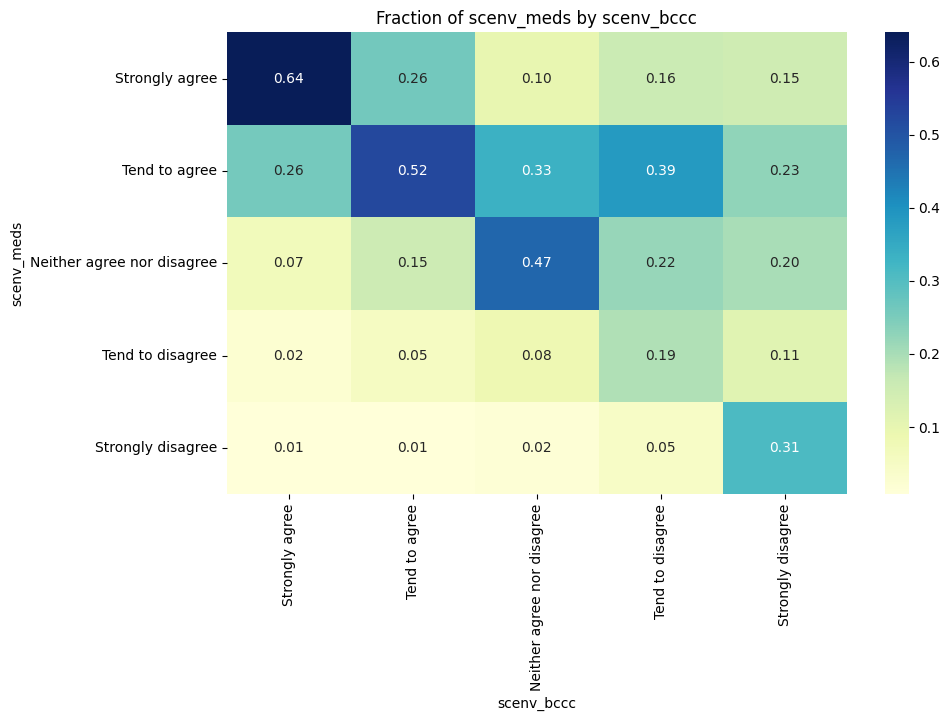

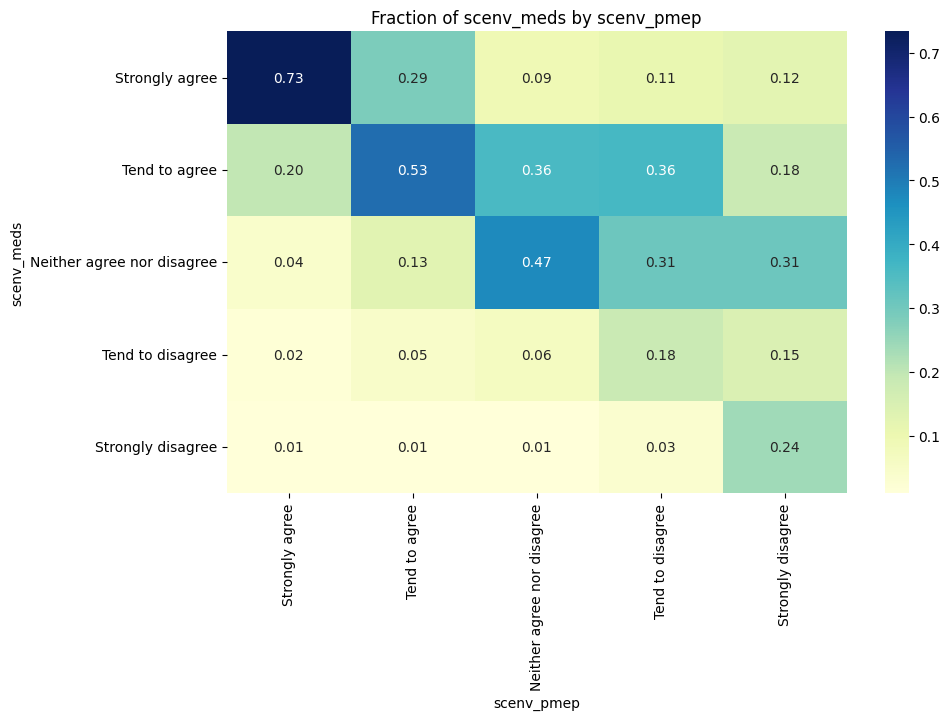

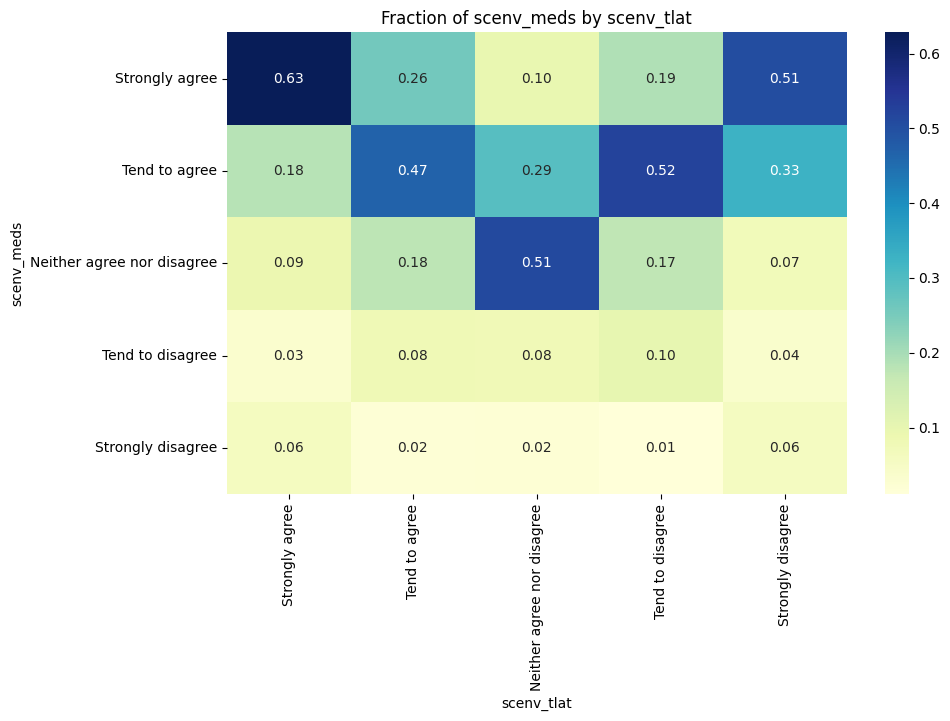

In [10]:
for variable in profiling_variables:
    visualise_heatmap(stata_response_wave_ten, ukhls_variable, variable)

In [ ]:
def write_balanced_responses_to_json(input_data, variable_name):

    num_rows = input_data.shape[0]

    print(num_rows)
    
    unique_indices = random.sample(range(num_rows), 10)

    # generate 10 random responses for each response type

    for random_index in unique_indices:
        random_row = input_data.iloc[random_index]
        profile_string, opinion_string = visualise_ukhls_profile_and_response(random_row, variable_name)

        if variable_name == "scenv_crlf":

            demo_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_demo_question_responses_h1.json"

            # write the profile and opinion to a json file
            with open(demo_json_filepath, "r") as file:
                output_data = json.load(file)

            output_data["profiles"].append(profile_string)
            output_data["opinions"].append(opinion_string)
            
            with open(demo_json_filepath, "w") as file:
                json.dump(output_data, file, indent=4)

        if variable_name == "scenv_bccc":

            question_one_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_question_one_responses_h1.json"

            # write the profile and opinion to a json file
            with open(question_one_json_filepath, "r") as file:
                output_data = json.load(file)

            output_data["profiles"].append(profile_string)
            output_data["opinions"].append(opinion_string)
            
            with open(question_one_json_filepath, "w") as file:
                json.dump(output_data, file, indent=4)

        if variable_name == "scenv_pmep":

            question_two_json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_question_two_responses_h1.json"

            # write the profile and opinion to a json file
            with open(question_two_json_filepath, "r") as file:
                output_data = json.load(file)

            output_data["profiles"].append(profile_string)
            output_data["opinions"].append(opinion_string)
            
            with open(question_two_json_filepath, "w") as file:
                json.dump(output_data, file, indent=4)

In [ ]:
scenv_pmep_strongly_agree = stata_response_wave_ten[stata_response_wave_ten["scenv_pmep"] == "Strongly agree"]
scenv_pmep_disagree = stata_response_wave_ten[stata_response_wave_ten["scenv_pmep"] == "Tend to agree"]
scenv_pmep_neutral = stata_response_wave_ten[stata_response_wave_ten["scenv_pmep"] == "Neither agree nor disagree"]
scenv_pmep_tend_to_disagree = stata_response_wave_ten[stata_response_wave_ten["scenv_pmep"] == "Tend to disagree"]
scenv_pmep_strongly_disagree = stata_response_wave_ten[stata_response_wave_ten["scenv_pmep"] == "Strongly disagree"]

In [ ]:
write_balanced_responses_to_json(scenv_pmep_strongly_agree, "scenv_pmep")
write_balanced_responses_to_json(scenv_pmep_disagree, "scenv_pmep")
write_balanced_responses_to_json(scenv_pmep_neutral, "scenv_pmep")
write_balanced_responses_to_json(scenv_pmep_tend_to_disagree, "scenv_pmep")
write_balanced_responses_to_json(scenv_pmep_strongly_disagree, "scenv_pmep")

In [ ]:
# convert "Stata-Results/stata_demo_question_responses_wave_ten_demo.json" to "Stata-Results/stata_demo_question_responses_wave_ten_demo.jsonl"
def convert_json_to_jsonl(json_file_path, jsonl_file_path):
    # format the responses in this structure "{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}"
    with open(json_file_path, "r") as file:
        data = json.load(file)

    # {"role": "system", "content": "You are a happy assistant that puts a positive spin on everything."}
    # {"role": "user", "content": "I fell off my bike today."}

    with open(jsonl_file_path, "w") as file:
        for i in range(len(data["profiles"])):
            # Prepare system prompt
            system_prompt = {"role": "system", "content": data["profiles"][i]}
            
            # Prepare assistant response
            assistant_response = {"role": "assistant", "content": data["opinions"][i]}

            # Create a message list and wrap it in a dictionary
            message_dict = {"messages": [system_prompt, assistant_response]}
            
            # Dump the dictionary as a JSON formatted string to the JSONL file
            json.dump(message_dict, file)
            file.write("\n")

In [ ]:
question_two_json_path = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_question_two_responses_h1.json"
question_two_jsonl_path = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Stata-Results\\stata_question_two_responses_h1.jsonl"
convert_json_to_jsonl(question_two_json_path, question_two_jsonl_path)

In [ ]:
openai_conditioned_model = OpenAI()
from api_key import get_api_key
api_key = get_api_key()

In [ ]:
def fine_tune_model(path, api_key):
    client = OpenAI(api_key = api_key)

    response = client.files.create(
        file=open(path, 'rb'),
        purpose = 'fine-tune'
    )

    print(response)
    response_id = response.id

In [ ]:
fine_tune_model(question_two_jsonl_path, api_key)

In [ ]:
model_id = "file-jNmxB6hkRPMe9mShW0rKA9HE"

In [ ]:
openai_conditioned_model.fine_tuning.jobs.create(training_file=model_id, model="gpt-3.5-turbo")

In [ ]:
question_two_model_id = "ft:gpt-3.5-turbo-0125:personal::9mmYVpj9"
question_number = 3
question_two = "To which extent strongly do you agree or disagree with the following statement: 'I would be prepared to pay more for environmentally friendly products.'?"
question_two_response_options = ["Strongly agree", "Tend to agree", "Neither agree nor disagree", "Tend to disagree", "Strongly disagree"]
n_samples = 100
json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Synthetic-Responses-JSON\\question_two_responses_finetuned.json"
distributions = [load_environmental_distribution("scenv_pmep", 4), load_environmental_distribution("scenv_pmep", 10)]
wave_numbers = [4, 10]
is_simulate = True

In [ ]:
simulate_environmental_responses(question_two, question_number, question_two_response_options, n_samples, json_filepath, distributions, wave_numbers, 1, is_simulate, 0, "", True, question_two_model_id)

In [ ]:
def temp_visualise_comparison(d1_path, d2_path, n_samples):
    with open(d1_path, "r") as file:
        d1_data = json.load(file)

    d1_data = d1_data[0]["Synthetic Responses"]

    print(d1_data)

    with open(d2_path, "r") as file:
        d2_data = json.load(file)

    # multiply by n_samples
    d2_data = {k: round(v * n_samples) for k, v in d2_data.items()}

    print(d2_data)

    x = range(len(d1_data))
    width = 0.35

    fig, ax = plt.subplots()

    rect1 = ax.bar(x, d1_data.values(), width, label="Fine-tuned Synthetic Responses")
    rect2 = ax.bar([i + width for i in x], d2_data.values(), width, label="UKHLS Responses")

    ax.set_ylabel("Number of Responses")

    ax.set_xticks([i + width / 2 for i in x])

    ax.set_xticklabels(d1_data.keys(), rotation=90)

    ax.legend()

    import textwrap as tw

    ax.set_xticklabels([tw.fill(label, 10) for label in d1_data.keys()])

    plt.savefig("C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\temp_comparison.png", bbox_inches='tight')

    plt.show()

In [ ]:
# manually visualise comparison between these json files
json_filepath = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Synthetic-Responses-JSON\\question_two_responses_finetuned.json"
d1_path = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Environmental-Views-Variables\\scenv_pmep\\Scenv Pmep Probability Distribution Wave 4.json"
d2_path = "C:\\Users\\haoch\\Documents\\COMP0190\\Data\\COMP0191-MSc-Project-Code\\Environmental-Views-Variables\\scenv_pmep\\Scenv Pmep Probability Distribution Wave 10.json"

# visualise bar chart comparing json filepath with d1_path
temp_visualise_comparison(json_filepath, d2_path, n_samples)